# Benchmark Comparison

This notebook demonstrates how to run benchmarks using the command line interface and visualize the results. It additionally compares QuASAr's native backends with external simulators from Qiskit Aer and MQT DD.


In [1]:
import json
import sys
import subprocess
import tempfile
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


In [2]:
tmp = Path(tempfile.gettempdir())/"quasar_cli_example"
subprocess.run([sys.executable, "../benchmark_cli.py", "--circuit", "ghz", "--qubits", "2:5", "--repetitions", "2", "--output", str(tmp)], check=True)

cli_df = pd.read_csv(tmp.with_suffix(".csv"))

cli_df


,circuit,qubits,framework,repetitions,avg_time,time_variance,avg_total_time,total_time_variance,avg_prepare_peak_memory,prepare_peak_memory_variance,avg_run_peak_memory,run_peak_memory_variance
0,ghz_circuit,2,statevector,2,0.004285,8.243224e-07,0.004291,8.232550e-07,80,0,50040.0,9.887251e+08
1,ghz_circuit,3,statevector,2,0.001800,5.199924e-09,0.001803,5.195959e-09,80,0,18691.0,1.988100e+04
2,ghz_circuit,4,statevector,2,0.001822,6.714901e-09,0.001825,6.724984e-09,80,0,19368.5,1.440202e+05
3,ghz_circuit,5,statevector,2,0.001820,9.204486e-11,0.001823,9.244825e-11,112,0,19678.5,6.162250e+03


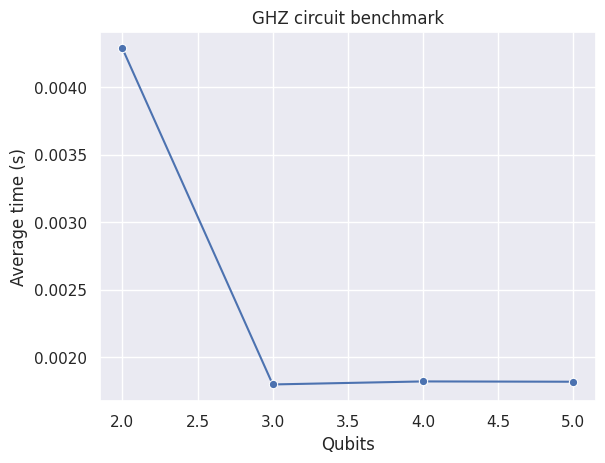

In [3]:
sns.lineplot(data=cli_df, x="qubits", y="avg_time", marker="o")
plt.title("GHZ circuit benchmark")
plt.xlabel("Qubits")
plt.ylabel("Average time (s)")
plt.show()

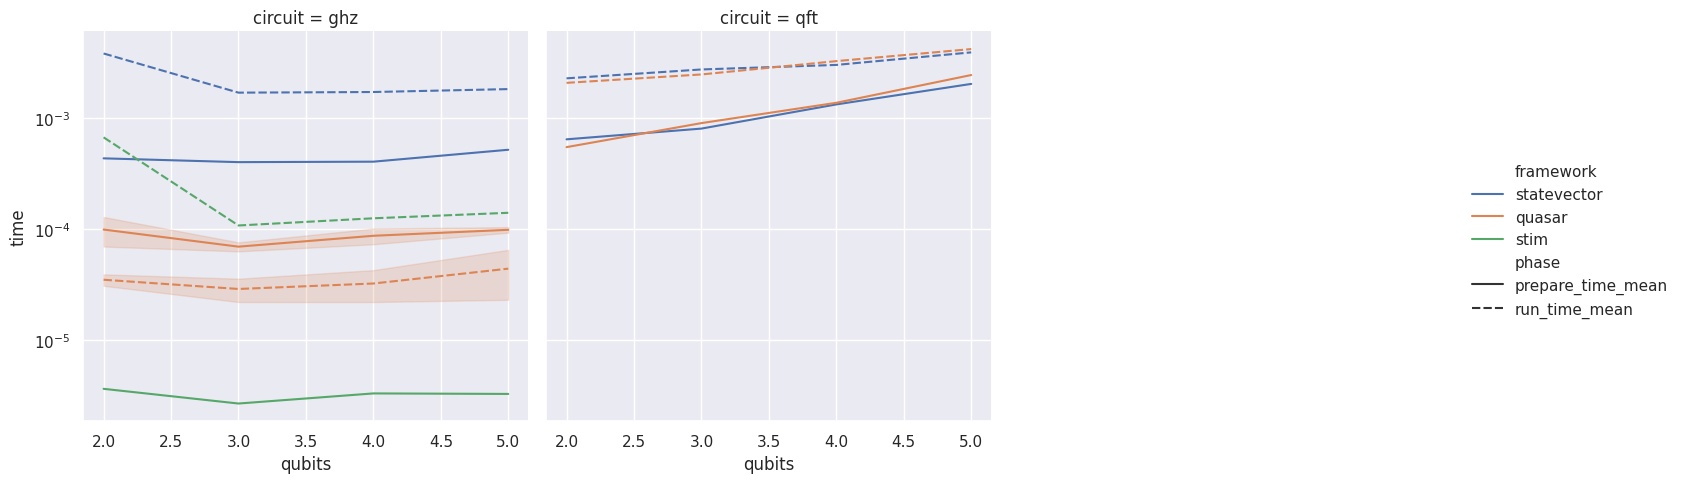

,circuit,framework,backend,qubits,prepare_time_mean,run_time_mean,total_time_mean
0,ghz,statevector,statevector,2,0.000432,0.003771,0.004202
1,ghz,quasar,TABLEAU,2,0.000128,0.000039,0.000168
2,ghz,stim,stim,2,0.000004,0.000666,0.000669
3,ghz,quasar,TABLEAU,2,0.000070,0.000031,0.000101
4,ghz,statevector,statevector,3,0.000399,0.001678,0.002077
5,ghz,quasar,TABLEAU,3,0.000076,0.000036,0.000112
6,ghz,stim,stim,3,0.000003,0.000108,0.000110
7,ghz,quasar,TABLEAU,3,0.000063,0.000022,0.000085
8,ghz,statevector,statevector,4,0.000403,0.001700,0.002103
9,ghz,quasar,TABLEAU,4,0.000101,0.000043,0.000144


In [4]:
nb_root = Path('..' ).resolve()
sys.path.append(str(nb_root))
sys.path.append(str(nb_root.parent))

from runner import BenchmarkRunner
from backends import (
    StatevectorAdapter,
    StimAdapter,
    MPSAdapter,
    DecisionDiagramAdapter,
)
import circuits as circuit_lib
from quasar import SimulationEngine
from quasar.cost import Backend

backends = [StatevectorAdapter(), StimAdapter()]
runner = BenchmarkRunner()
engine = SimulationEngine()

circuits = {
    'ghz': circuit_lib.ghz_circuit,
    'qft': circuit_lib.qft_circuit,
}

qubit_sizes = list(range(2, 6))

for name, build in circuits.items():
    for n in qubit_sizes:
        try:
            circ = build(n)
        except Exception:
            continue
        for b in backends:
            try:
                rec = runner.run_multiple(circ, b, return_state=False, repetitions=3)
                rec['circuit'] = name
                rec['qubits'] = n
                rec['backend'] = b.name
            except Exception:
                pass
            try:
                kwargs = {'repetitions': 3}
                if b.name == 'stim':
                    kwargs['backend'] = Backend.TABLEAU
                rec = runner.run_quasar_multiple(
                    circ,
                    engine,
                    **kwargs,
                )
                rec['circuit'] = name
                rec['qubits'] = n
            except Exception:
                pass


df = pd.DataFrame(runner.results)
df_long = df.melt(
    id_vars=['circuit', 'framework', 'backend', 'qubits'],
    value_vars=['prepare_time_mean', 'run_time_mean'],
    var_name='phase',
    value_name='time',
)
g = sns.relplot(
    data=df_long,
    x='qubits',
    y='time',
    hue='framework',
    style='phase',
    col='circuit',
    col_wrap=3,
    kind='line',
)
g.set(yscale='log')
plt.show()
df[['circuit', 'framework', 'backend', 'qubits', 'prepare_time_mean', 'run_time_mean', 'total_time_mean']]


These results separate the **preparation** time from the actual **simulation** run time. Preparation typically includes converting circuits or planning steps, whereas simulation measures the time spent executing the circuit. The table and plot above illustrate how both components contribute to the total runtime.

In [5]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [6]:
# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f'../results/{nb_name}_params.json', 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f'../results/{nb_name}_results.json', 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import json\nimport sys\nimport subprocess\nimport tempfile\nfrom pathlib import Path\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nsns.set_theme()",
    "tmp = Path(tempfile.gettempdir())/\"quasar_cli_example\"\nsubprocess.run([sys.executable, \"../benchmark_cli.py\", \"--circuit\", \"ghz\", \"--qubits\", \"2:5\", \"--repetitions\", \"2\", \"--output\", str(tmp)], check=True)\n\ncli_df = pd.read_csv(tmp.with_suffix(\".csv\"))\n\ncli_df",
    "sns.lineplot(data=cli_df, x=\"qubits\", y=\"avg_time\", marker=\"o\")\nplt.title(\"GHZ circuit benchmark\")\nplt.xlabel(\"Qubits\")\nplt.ylabel(\"Average time (s)\")\nplt.show()",
    "nb_root = Path('..' ).resolve()\nsys.path.append(str(nb_root))\nsys.path.append(str(nb_root.parent))\n\nfrom runner import BenchmarkRunner\nfrom backends import (\n    StatevectorAdapter,\n    StimAdapter,\n    MPSAdapter,\n    DecisionDiagramAdapter,\n)\nimport circuits as circuit_lib\nfrom quasar import S